In [14]:
%load_ext autoreload
%autoreload 2

import src.ksd.models as models
from src.ksd.find_modes import find_modes, pairwise_directions, run_bfgs
from src.ksd.langevin import RandomWalkMH, RandomWalkBarker
import src.ksd.langevin as mcmc
from src.ksd.ksd import KSD
from src.ksd.kernel import IMQ
from src.ksd.bootstrap import Bootstrap
from src.ksd.find_modes import find_modes, pairwise_directions
from tqdm.notebook import tqdm, trange

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import matplotlib.pyplot as plt
import seaborn as sns

import src.kgof.density as density
import src.kgof.data as data

from src.nf_maf import init_model, show, load_and_preprocess_mnist
import pickle

MCMCKernel = RandomWalkMH # RandomWalkBarker 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
checkpoint, maf, batched_train_data = init_model()

2022-04-18 12:49:59.325243: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-04-18 12:49:59.325285: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:169] retrieving CUDA diagnostic information for host: nvidia4
2022-04-18 12:49:59.325291: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:176] hostname: nvidia4
2022-04-18 12:49:59.325411: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:200] libcuda reported version is: 460.27.4
2022-04-18 12:49:59.325429: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:204] kernel reported version is: 460.27.4
2022-04-18 12:49:59.325433: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:310] kernel version seems to match DSO: 460.27.4
2022-04-18 12:49:59.325721: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in pe

Successfully initialized!
Successfully loaded trained model!


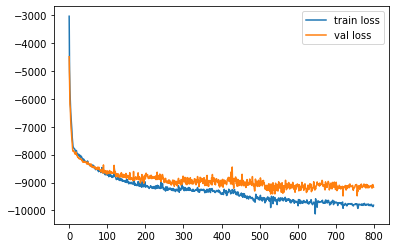

In [3]:
res_dir = "res/tmp_10_256"
loss_hist = pickle.load(open(f"{res_dir}/loss_hist.pkl", "rb"))
global_step = loss_hist["global_step"]
train_losses = loss_hist["train_losses"]
val_losses = loss_hist["val_losses"]

# plot train and validation loss curve
plt.plot(global_step, train_losses, label="train loss")
plt.plot(global_step, val_losses, label="val loss")
plt.legend()

In [4]:
xx = maf.sample(20)

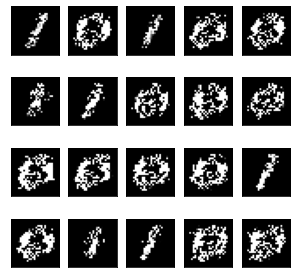

In [5]:
show(xx)

# KSD test

In [6]:
# can only run once!
log_prob_old = maf.log_prob

def maf_log_prob(img):
    img = tf.reshape(img, (-1, 28, 28))
    return log_prob_old(img)

maf.log_prob = maf_log_prob

In [15]:
tf.random.set_seed(1)

n = 300

num in classes in train: [(1, 5678)]
num in classes in val: [(1, 1064)]
num in classes in test: [(1, 1135)]


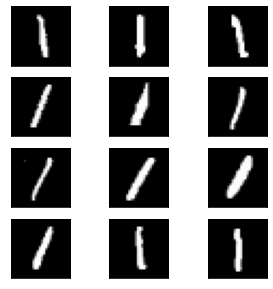

In [16]:
# take digits 1 only
sample_batch, _, _, _ = load_and_preprocess_mnist(logit_space=True, batch_size=128, classes=[1])
train_data_tensor = tf.concat(list(sample_batch), axis=0)

ind = np.random.randint(0, train_data_tensor.shape[0], size=n).tolist()
sample_off = np.take(train_data_tensor, ind, axis=0)
sample_off = tf.reshape(sample_off, (-1, 28*28))

show(np.take(train_data_tensor, ind, axis=0)[:12])

In [17]:
sample_on = tf.convert_to_tensor(maf.sample(n), dtype=tf.float32)
sample_on = tf.reshape(sample_on, (-1, 28*28))

In [18]:
num_boot = 800
alpha = 0.05
nrep = 1

kernel = IMQ(med_heuristic=True)
ksd = KSD(target=maf, kernel=kernel)

In [19]:
# initialise bootstrap
bootstrap_nopert = Bootstrap(ksd, n)
multinom_samples_notrain = bootstrap_nopert.multinom.sample((nrep, num_boot)) # nrep x num_boot x n

In [20]:
## KSD
multinom_one_sample = multinom_samples_notrain[0, :] # nrep x num_boost x n

# compute p-value
rej_on, pval_on = bootstrap_nopert.test_once(
    alpha=alpha, num_boot=num_boot,X=sample_on, multinom_samples=multinom_one_sample)

rej_off, pval_off = bootstrap_nopert.test_once(
    alpha=alpha, num_boot=num_boot,X=sample_off, multinom_samples=multinom_one_sample)

2022-04-18 14:54:46.970196: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 221276160000 exceeds 10% of free system memory.
2022-04-18 14:55:01.189232: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 221276160000 exceeds 10% of free system memory.
2022-04-18 14:55:16.178026: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 221276160000 exceeds 10% of free system memory.
2022-04-18 14:55:35.123944: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 221276160000 exceeds 10% of free system memory.
2022-04-18 14:56:02.144859: W tensorflow/core/framework/cpu_allocator_impl.cc:80] Allocation of 221276160000 exceeds 10% of free system memory.


In [13]:
print("on p-value:", pval_on, "off p-value:", pval_off)

on p-value: 0.0299625468164794 off p-value: 0.9675405742821473


In [21]:
print("on p-value:", pval_on, "off p-value:", pval_off)

on p-value: 0.06991260923845194 off p-value: 0.418227215980025
